In [63]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from fooof import FOOOF, FOOOFGroup
from neurodsp import sim, spectral
from seaborn import despine

from scipy import io, stats, optimize
from statsmodels.tsa.stattools import acf


sys.path.append('../')
import echo_utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

fig_path = '../figures/sim/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Timescale and 1/f
Power spectra of the Lorentzian form:

$$ P(f) = {A\over(k+f^2)} $$

have a characteristic timescale. Below I'm exploring the relationship between the timescale in time domain, directly defined by the decay time constant of the kernel and the power law exponent ('slope') and 'knee' measured in the frequency domain.

# Exponentially Decaying Synaptic Potentials
Synaptic currents are almost always modeled as exponentially decaying (or alpha-shaped) functions, which has a plateau up to some characteristic frequency (knee), and a power-law decay with exponent of 2 past that. The decay time constant maps one-to-one onto the knee frequency:

$\tau = \frac{1}{2\pi}\sqrt[\chi]{\frac{1}{k}}$, and 

$f_{knee}\approx\sqrt[\chi] k$

Here, $\chi=2$ for exponentially decaying signals, but this can also vary in brain signals as a function of brain region and task engagement.

- http://mathworld.wolfram.com/FourierTransformExponentialFunction.html
- http://www.thefouriertransform.com/pairs/decayingexponential.php

In [6]:
fs = 2000.
t_sim = 2.
t_ker = np.arange(0,t_sim,1/fs)
t_r = 0
t_ds = np.arange(0.005,0.08,0.01)
f_to_plot=200
kernels = []

# get synaptic kernels
for t_d in t_ds:
    ker = sim.sim_synaptic_kernel(t_sim, fs, tau_r=t_r, tau_d=t_d)
    kernels.append(ker/ker[0])

kernels = np.array(kernels).T

# compute spectrum
f_axis = np.fft.fftfreq(len(t_ker), 1/fs)[:int(np.floor(len(t_ker)/2))]
PSDs = (np.abs(sp.fft(kernels, axis=0))**2)[:len(f_axis)]

# fit FOOOF & get knee parameter
fooof = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fooof.fit(freqs=f_axis, power_spectra=PSDs.T,freq_range=(2,200))
fit_knee = fooof.get_params('aperiodic_params', 'knee')
fit_exp = fooof.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)

P_knee = [PSDs[np.argmin(np.abs((f_axis[:f_to_plot]-(knee_freq[i])))),i] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/rdgao/opt/anaconda3/envs/voytek/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


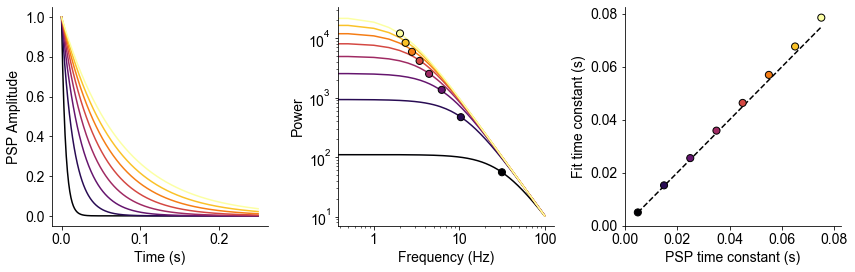

In [7]:
color = plt.cm.inferno(np.linspace(0,1,len(t_ds)))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(t_ker[:500], kernels[:500,:])
plt.xlabel('Time (s)'); plt.ylabel('PSP Amplitude')

plt.subplot(1,3,2)
plt.loglog(f_axis[:f_to_plot], PSDs[:f_to_plot,:]);
plt.scatter(knee_freq,P_knee, c=color, s=50, edgecolor='k', zorder=100)
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power')
plt.xticks([1, 10, 100], ['1','10','100'])

plt.subplot(1,3,3)
plt.scatter(t_ds,taus, c=color, s=50, edgecolor='k', zorder=100)
plt.plot(t_ds, t_ds, 'k--');
plt.xlim([0,t_ds.max()*1.1]);plt.ylim([0,t_ds.max()*1.1])
plt.xlabel('PSP time constant (s)'); plt.ylabel('Fit time constant (s)')
[despine() for a in plt.gcf().axes]
plt.tight_layout()

if save_plot: plt.savefig(fig_path%'kernel_analytic')

# Spontaneous Synaptic Fluctuations
Using those synaptic kernels with varying decay constants, we can simulate synaptic fluctuations over time by simply convolving white noise (approximating Poisson population spiking) with the kernels. This will produce time series with varying autocorrelation time constants, and thus PSD knees. We will then FOOOF and fit the knee parameter, retrieve the time constant with the equation above, and confirm that we get back the parameter values we put in.

In [42]:
# simulate noise
T = 240
noise, ac = [], []
for t_d in t_ds:
    noise.append(sim.sim_synaptic_current(T, fs, tau_d = t_d))
    ac.append(sp.signal.correlate(noise[-1], noise[-1])[int(T*fs)-1:])

noise = np.vstack(noise)
ac = np.vstack(ac).T

f_axis, PSD = spectral.compute_spectrum(noise,fs)

# FOOOF PSDs without knee
fg = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fg.fit(freqs=f_axis, power_spectra=PSD, freq_range=(2,200))
fit_knee = fg.get_params('aperiodic_params', 'knee')
fit_exp = fg.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)
P_knee = [PSD[i,np.argmin(np.abs((f_axis[:f_to_plot]-(knee_freq[i]))))] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



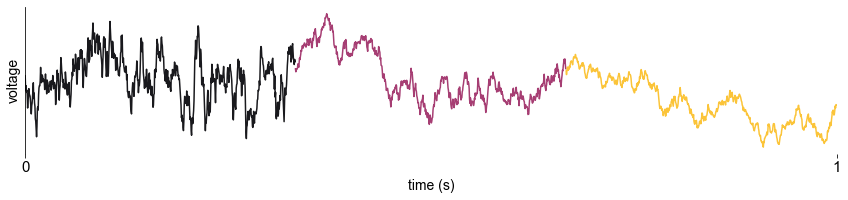

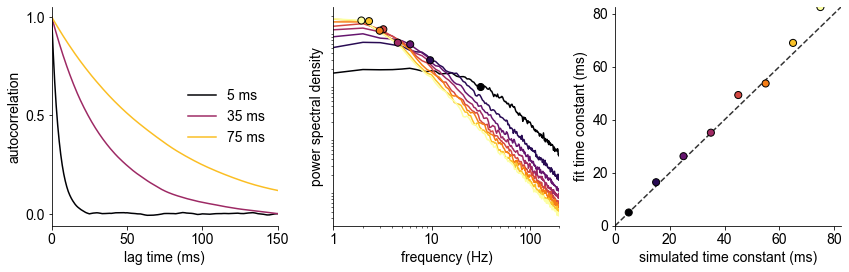

In [58]:
i_plot = [0,3,7]
t = np.arange(0,T,1/fs)

plt.figure(figsize=(12,3))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0,0.85,3)))
plt.plot(t[:int(fs/3)], noise.T[:int(fs/3),i_plot[0]], alpha=0.9)
plt.plot(t[int(fs/3):int(2*fs/3)], noise.T[int(fs/3):int(2*fs/3),i_plot[1]], alpha=0.9)
plt.plot(t[int(2*fs/3):int(fs)], noise.T[int(2*fs/3):int(fs),i_plot[2]], alpha=0.9)
plt.xlabel('time (s)'); plt.ylabel('voltage')
plt.yticks([])
plt.xticks([0,1], fontsize=15); plt.xlim([0,1]); despine(bottom=True)
plt.tight_layout()
#plt.legend(['Fast', 'Medium', 'Slow'])
#plt.legend(['Fast', 'Medium', 'Slow'], loc='lower left', bbox_to_anchor= (1, 0), ncol=1, frameon=False)
#plt.legend(['Fast', 'Medium', 'Slow'], loc='upper right', ncol=1, frameon=False)
if save_plot: plt.savefig(fig_path%'noise_ts_seg', bbox_inches='tight')

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(t_ker[:500]*1000, ac[:500,i_plot]/ac[0,i_plot])
plt.xlim([0,150]),plt.yticks([0,0.5,1])
plt.xlabel('lag time (ms)'); plt.ylabel('autocorrelation')
plt.legend(['%i ms'%np.round(tt) for tt in t_ds[i_plot]*1000], frameon=False, loc='right')

plt.rcParams['axes.prop_cycle'] = plt.cycler('color',color)
plt.subplot(1,3,2)
plt.loglog(f_axis[:f_to_plot], PSD[:,:f_to_plot].T);
plt.scatter(knee_freq,P_knee, c=color, s=50, edgecolor='k', zorder=100)
plt.yticks([])
plt.xlabel('frequency (Hz)'); plt.ylabel('power spectral density')
plt.xticks([1, 10, 100], ['1','10','100']); plt.xlim([1,200])

plt.subplot(1,3,3)
plt.scatter(t_ds*1000,taus*1000, c=color, s=50, edgecolor='k', zorder=100)
plt.xlim([0,t_ds.max()*1100]);plt.ylim([0,t_ds.max()*1100])
plt.plot(plt.xlim(), plt.xlim(), 'k--', alpha=0.8);
plt.xlabel('simulated time constant (ms)'); plt.ylabel('fit time constant (ms)')
[despine() for a in plt.gcf().axes]
plt.tight_layout()

if save_plot: plt.savefig(fig_path%'noise_spectral')

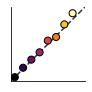

In [54]:
# plot a smaller one for inset
plt.figure(figsize=(1.5,1.5))
plt.scatter(t_ds*1000,taus*1000, c=color, s=50, edgecolor='k', zorder=100)
#plt.xlim([0,t_ds.max()*1100]);plt.ylim([0,t_ds.max()*1100])
plt.xticks([]);plt.yticks([])
plt.xlim([0,90]);plt.ylim([0,90])
plt.plot(plt.xlim(), plt.xlim(), 'k--', alpha=0.8);
#plt.xlabel('Groud Truth (ms)'); plt.ylabel('Fit (ms)')
despine()
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'sim_corr_inset', bbox_inches='tight')

# Success!
As expected, we can retrieve autocorrelation decay time constants (timescale) from the power spectrum, even in stochastic signals. The advantage of this approach, fitting in the frequency domain, is that oscillations manifest as distinct narrowband peaks in the PSD, and are easily isolated and removed (by FOOOF). In contrast, oscillations in the autocorrelation function are difficult to account for, and we essentially have to fit the envelope, in addition to long timescale/scalefree processes that "stretch out" the decay time constant.

### Example plots in semilog vs. loglog to emphasize the low-frequency plateau

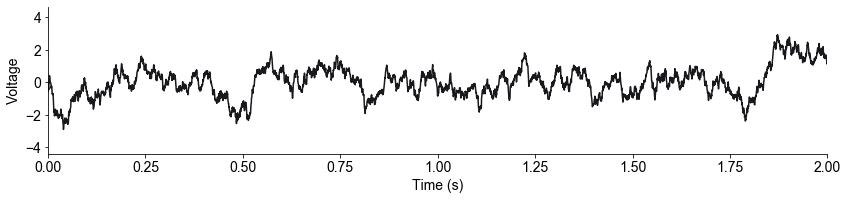

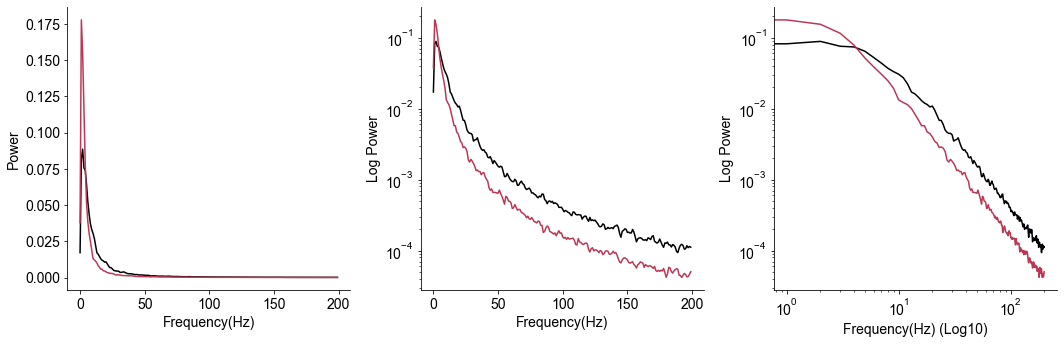

In [33]:
plt.figure(figsize=(12,3))

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0,1,3)))
plt.plot(t[:int(fs*30)], noise.T[:int(fs*30),5], alpha=0.9)
plt.xlabel('Time (s)'); plt.ylabel('Voltage')
plt.xlim([0,2]);despine()
plt.tight_layout()


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(f_axis[:f_to_plot], PSD[-6:-1:4,:f_to_plot].T);
plt.xlabel('Frequency(Hz)');plt.ylabel('Power')

plt.subplot(1,3,2)
plt.semilogy(f_axis[:f_to_plot], PSD[-6:-1:4,:f_to_plot].T);
plt.xlabel('Frequency(Hz)');plt.ylabel('Log Power')


plt.subplot(1,3,3)
plt.loglog(f_axis[:f_to_plot], PSD[-6:-1:4,:f_to_plot].T);
plt.xlabel('Frequency(Hz) (Log10)');plt.ylabel('Log Power')
despine()
plt.tight_layout()

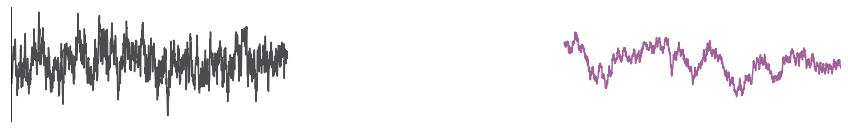

In [60]:
plt.figure(figsize=(12,2))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.inferno(np.linspace(0,1,4)))
plt.plot(t[:int(fs)], noise.T[:int(fs),0], alpha=0.7)
#plt.plot(t[int(fs*1.5):int(fs*2)], noise.T[:int(fs/2),-1], alpha=0.7)
plt.plot(t[int(fs*2):int(fs*3)], noise.T[:int(fs),-1], alpha=0.7)
plt.yticks([])
plt.xlim([0,3]); 
#plt.xticks([0,0.9], ['0', '900 ms'], fontsize=20)
plt.xticks([])
despine(bottom=True, left=False); plt.tight_layout()
if save_plot: plt.savefig('../figures/jwm/schematic.png')

In [61]:
datafolder = '/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120802PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session1/'
chan = 20 #45 #20 #127
data_exmp = io.loadmat(datafolder+'ECoG_ch%i.mat'%chan, squeeze_me=True)['ECoGData_ch%i'%chan]
cond = io.loadmat(datafolder+'Condition.mat', squeeze_me=True)
data = data_exmp[cond['ConditionIndex'][2]:cond['ConditionIndex'][3]]
fs = 1000


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

19.39452438346076 0.008206179225906633 3.8147519723025356


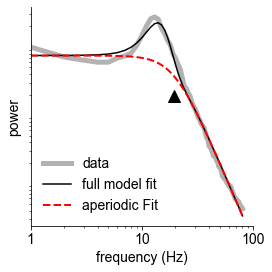

In [64]:
fit_range=[1,80]
plt_inds = np.arange(fit_range[0],fit_range[1]+1)
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median')

# fit fooof without knee
fo0 = FOOOF(max_n_peaks=2, aperiodic_mode='fixed')
fo0.fit(faxis, psd, fit_range)

# fit fooof with knee
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
print(kfreq, tau, exp)

plt.figure(figsize=(4,4))
plt.loglog(faxis[plt_inds], psd[plt_inds], 'k', lw=5, alpha=0.3)
#plt.loglog(faxis[plt_inds], 10**fo0.fooofed_spectrum_)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')



plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--r', lw=2)
plt.xlim([1,100])
plt.xlabel('frequency (Hz)');plt.ylabel('power');
plt.xticks([1, 10, 100], ['1','10', '100']);plt.yticks([]);
plt.legend(['data', 'full model fit', 'aperiodic Fit'], frameon=False)
#plt.plot(kfreq, plt.ylim()[1]*0.9, '^k', ms=12)

plt.plot(kfreq, 10**offset/(knee+faxis**exp)[np.where(faxis==np.round(kfreq))[0]]*0.5, '^k', ms=12)

despine(); plt.tight_layout()
plt.savefig(fig_path%'fooof_schematic')

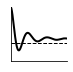

In [65]:
# compute autocorrelation function
max_lag=250
t_ac = np.arange(0,max_lag+1)/fs
ac = acf(data, nlags=max_lag, fft=True)

# plot a tiny autocorrelation function for inset
plt.figure(figsize=(1,1))
plt.plot(t_ac*1000, ac, 'k', lw=2)
plt.axhline(0, lw=1, ls='--', color='k')
plt.xlim([0,250])
plt.xticks([]); plt.yticks([]); plt.ylim([-0.5,1])
despine()
plt.savefig(fig_path%'acf_schematic')

short tau = 8.907 ms
long tau = 1539.033 ms


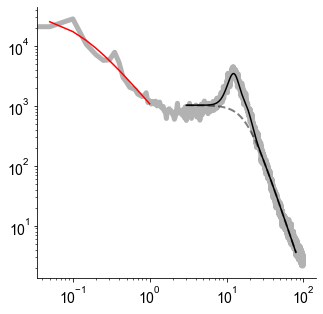

In [66]:
winlen = 20
faxis, psd = spectral.compute_spectrum(data,fs,avg_type='median', nperseg=int(fs*winlen), noverlap=int(fs*winlen*3/4))

plt.figure(figsize=(5,5))
plt.loglog(faxis[:winlen*100], psd[:winlen*100], 'k', lw=5, alpha=0.3)


# fit fooof with high knee
fit_range=[3,80]
plt_inds = np.arange(fit_range[0]*winlen, fit_range[1]*winlen+1).astype(int)
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'k-')
plt.loglog(faxis[plt_inds], 10**offset/(knee+faxis**exp)[plt_inds], '--k', lw=2, alpha=0.5)
print('short tau = %.3f ms'%(tau*1000))

# fit fooof with low knee
fit_range=[0.05,1]
plt_inds = np.arange(fit_range[0]*winlen, fit_range[1]*winlen+1).astype(int)
fok = FOOOF(max_n_peaks=2, aperiodic_mode='knee')
fok.fit(faxis, psd, fit_range)
offset, knee, exp = fok.get_params('aperiodic_params')
kfreq, tau = echo_utils.convert_knee_val(knee,exp)
plt.loglog(faxis[plt_inds], 10**fok.fooofed_spectrum_, 'r-')

print('long tau = %.3f ms'%(tau*1000))
despine()

single tau = 9.221 ms
short tau = 8.749 ms, long tau = 1381.189 ms


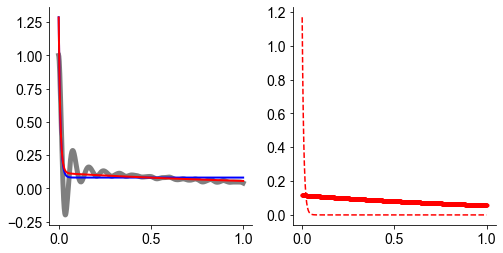

In [67]:
# compute autocorrelation function
max_lag=1000
t_ac = np.arange(0,max_lag+1)/fs
ac = acf(data, nlags=max_lag, fft=True)

p_bounds =([0, 0, 0], [10, np.inf, np.inf])
p_le = optimize.curve_fit(echo_utils.exp_lt_func, t_ac, ac, bounds = p_bounds)[0]
print('single tau = %.3f ms'%(p_le[0]*1000))
p_bounds =([0, 0, 0, 0, 0], [10, 10, np.inf, np.inf, np.inf])
p_2e = optimize.curve_fit(echo_utils.exp2_func, t_ac, ac, bounds = p_bounds)[0]


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_ac, ac, 'k', lw=5, alpha=.5)
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_le[0],p_le[1],p_le[2]), 'b', lw=2)
plt.plot(t_ac, echo_utils.exp2_func(t_ac, p_2e[0],p_2e[1],p_2e[2], p_2e[3],p_2e[4]), 'r', lw=2)
despine()

plt.subplot(1,2,2)
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_2e[0],p_2e[2],0), 'r--')
plt.plot(t_ac, echo_utils.exp_lt_func(t_ac, p_2e[1],p_2e[3],0), 'r.-')
despine()
print('short tau = %.3f ms, long tau = %.3f ms'%(min(p_2e[0],p_2e[1])*1000, max(p_2e[0],p_2e[1])*1000))